<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_5_2024_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Week 5 Practical: Analytical BRDF models

### This week we will start exploring BRDF models, working both on their analytical implementation (Part 1, tasks 1-3) and on their use for rendering (Part 2, task 4).

---




##Part 1: BRDF computation.

We will be implementing a phenomenological Bidirectional Reflectance Distribution Function (BRDF) model, specifically the standard *Ward* model (Task 1). Our primary focus will be on the essential components required to complete this task.

In Task 2 we will use this model to generate an in-plane scattering plot.

Task 3 will involve an exploration of one of the approximations of the Fresnel effect, commonly employed in Computer Graphics

We will employ the coordinate frame described below: the ***z***-axis aligns with the local surface normal ***n***, and both the ***x*** and ***y*** axes reside within the surface's tangent plane; the x-axis aligns with the tangent vector.


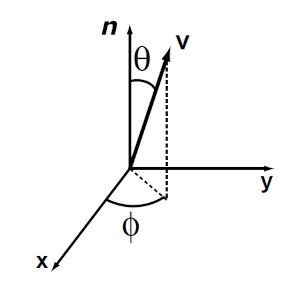




In [1]:
# Required libraries for tasks 1-4 and coordinate system definitions

# numpy and pyplot are required for tasks 1-3
import numpy as np
import matplotlib.pyplot as plt

# os and cv2 will be used in task 4
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

# Define the axes of our coordinate system
n = np.array([0, 0, 1]);
x = np.array([1, 0, 0]);
y = np.array([0, 1, 0]);


###Task 1: implementation of the Ward BRDF model
Recall that the equation for this model is given by:

$f_{r}(v_i,v_r)=\frac{\rho_d}{\pi}+\left[\frac{\rho_s}{4\pi\alpha_x\alpha_y\sqrt{\cos(\theta_i)\cos(\theta_r)}}\right] e^{-\frac{(\frac{\bf{h}\cdot\bf{x}}{\alpha_x})^2 +(\frac{\bf{h}\cdot\bf{y}}{\alpha_y})^2}{(\bf{h}\cdot\bf{n})^2}}$

Your task is to implement this equation.
For a more detailed explanation of the model, please refer to the video lecture "Phenomenological models."

We will assume that an input vector $v$ is provided to us in the form of **$v = (\theta, \phi)$**.

Since the *Ward* specular equation involves dot products, we will begin by converting vectors from polar to Cartesian coordinates.

In [74]:
def compute_vector_components(theta_v, phi_v):
    """
    Compute the vx, vy, and vz components of a vector v based on its polar coordinates.

    Args:
        theta_v: Polar angle in degrees.
        phi_v: Azimuthal angle in degrees.

    Returns:
        A tuple containing the x, y, and z components of the vector.
    """
    # projection of the vector on the z axis. Recall that we make use of normalised vectors
    vz = np.cos(theta_v)

    # projection of the vector on the xy plane
    xy_projection = np.sin(theta_v)

    # projection of the vector on the x and y axis
    vx = xy_projection * np.cos(phi_v)
    vy = np.sin(phi_v) * xy_projection
    return vx, vy, vz




def compute_halfway_vector(v_i, v_r):
    """
    Compute the halfway vector between two vectors.

    Args:
        v_i: Incoming vector.
        v_r: Reflective vector.

    Returns:
        Normalised halfway vector.
    """
    return (v_i + v_r) / np.linalg.norm(v_i + v_r)



# Implementation of the Ward BRDF
def ward_brdf(theta_i, phi_i, theta_r, phi_r, x, y, n, rho_d, rho_s, alpha_x, alpha_y):
    """
    Compute the value of the Ward BRDF model, given the surface parameters and lighting and viewing directions.

    Args:
        theta_i: Polar angle of the incident light.
        phi_i: Azimuthal angle of the incident light.
        theta_r: Polar angle of the reflection.
        phi_r: Azimuthal angle of the reflection.
        x, y, n: Axis of the coordinate system.
        rho_d: Diffuse albedo.
        rho_s: Specular albedo.
        alpha_x, alpha_y: Surface roughness parameters.

    Returns:
        BRDF value for the input parameters.
    """
    theta_i = np.deg2rad(theta_i)
    phi_i = np.deg2rad(phi_i)
    theta_r = np.deg2rad(theta_r)
    phi_r = np.deg2rad(phi_r)
    # Compute vector components for incoming and outgoing directions
    vi_x, vi_y, vi_z = compute_vector_components(theta_i, phi_i)
    vr_x, vr_y, vr_z = compute_vector_components(theta_r, phi_r)

    # Compute the halfway vector
    h = compute_halfway_vector(np.array([vi_x, vi_y, vi_z]).T, np.array([vr_x, vr_y, vr_z]).T)

    # BRDF calculation
    specular_denominator =  4 * np.pi * alpha_x * alpha_y * np.sqrt(np.cos(theta_r)*np.cos(theta_i))
    exponent = -((((np.dot(h, x))/alpha_x)**2 + ((np.dot(h, y))/alpha_y)**2)/(np.dot(h, n))**2)
    specular = np.dot(rho_s/specular_denominator, np.e**exponent)
    diffuse = rho_d / np.pi
    return diffuse + specular

###Task 2: Scattering plots

Now, you will draw the in-plane scattering plot for the Ward BRDF model.

Test your code using the incident direction $v_i(\theta_i = 30, \phi_i=270)$,
using the roughness parameters $\alpha_x = \alpha_y = 0.1$, with specular albedo $\rho_s=1$ and diffuse albedo $\rho_d=0$.

Your plot should resemble the following one:

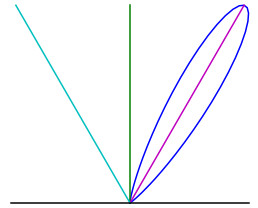

Subsequently, illustrate the scattering plots for:

1.   $v_i(\theta_i = 30, \phi_i=270)$, $\rho_d=0.7$, $\rho_s=0.1$, $\alpha_x = \alpha_y = 0.5$
2.   $v_i(\theta_i = 60, \phi_i=270)$, $\rho_d=0.7$, $\rho_s=0.1$, $\alpha_x = \alpha_y = 0.25$
3.   $v_i(\theta_i = 30, \phi_i=90)$, $\rho_d=0.7$, $\rho_s=0.1$, $\alpha_x = \alpha_y = 0.5$.

Remember: the viewing direction need to span the entire plane of incidence!



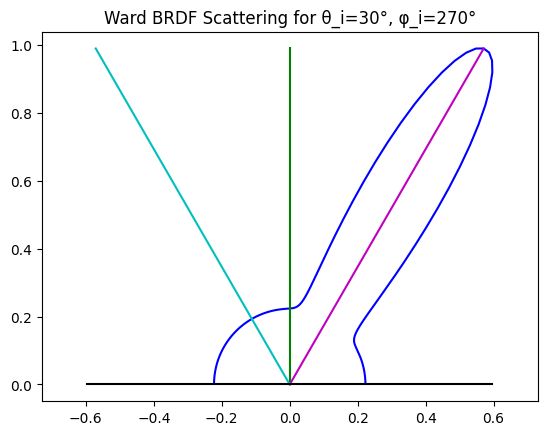

In [75]:
#This function will go through a (relatively) dense sampling of theta_r within the incidence plane (1 degree).
#As for phi_r, you need to account for the cases where phi_r = phi_i and phi_r = phi_i + pi (since we are dealing with in-plane scattering).
#Once you have computed the BRDF for each viewing direction as mentioned above, you can plot the shape of the lobe.

def get_inplane_scattering_plot_data(theta_i, phi_i, x, y, n, rho_d, rho_s, alpha_x, alpha_y):
    """
    Compute in-plane scattering data for plotting the Ward BRDF specular lobe.

    Args:
        theta_i: Polar angle of the incident light in degrees.
        phi_i: Azimuthal angle of the incident light in degrees.
        x, y, n: Axis of the coordinate system.
        rho_d: Diffuse albedo.
        rho_s: Specular albedo.
        alpha_x, alpha_y: Surface roughness parameters.

    Returns:
        Cartesian coordinates for plotting the BRDF lobe.
    """

    # Allocate memory for the data, skipping theta_r = 90 to avoid numerical issues
    scatter_lobe_x = np.empty(179)
    scatter_lobe_y = np.empty(179)

    # Loop to compute BRDF values for in-plane scattering
    # In our BRDF coordinate system, theta typically varies between 0 and 90 degrees.
    # To simplify the loop's logic, we'll allow theta_r to take on negative values when phi_r equals phi_i.
    for theta_r in range(-89, 90):
        phi_r = phi_i if theta_r < 0 else (phi_i + 180) % 360
        idx = theta_r + 89

        # Compute BRDF lobe value
        brdf = ward_brdf(theta_i, phi_i, abs(theta_r), phi_r, x, y, n, rho_d, rho_s, alpha_x, alpha_y)

        # Convert to Cartesian coordinates for plotting
        scatter_lobe_x[idx] = brdf * np.sin(np.deg2rad(theta_r)) # * np.sign(np.cos(np.deg2rad(phi_r)))
        scatter_lobe_y[idx] = brdf * np.cos(np.deg2rad(theta_r))
    return scatter_lobe_x, scatter_lobe_y



def plot_ward_brdf_scattering(theta_i, phi_i, x, y, n, rho_d, rho_s, alpha_x, alpha_y):
    """
    Plot the Ward BRDF scattering data for in-plane scattering.

    Args:
        theta_i, phi_i: Spherical coordinates of the incident light.
        x, y, n: Coordinate system axes.
        rho_d: Diffuse albedo.
        rho_s: Specular albedo.
        alpha_x, alpha_y: Surface roughness parameters.
    """

    # Compute the scattering data
    scatter_x, scatter_y = get_inplane_scattering_plot_data(theta_i, phi_i, x, y, n, rho_d, rho_s, alpha_x, alpha_y)

    # Scale and set plot properties
    max_y = np.max(scatter_y)
    max_x = np.max(np.abs(scatter_x))

    # surface normal n
    green_line = [0, 0], [0, max_y]
    # local surface
    black_line = [-max_x, max_x], [0, 0]
    # incoming direction
    cyan_line = [0, np.sign(np.sin(np.deg2rad(phi_i))) * max_y * np.tan(np.deg2rad(theta_i))], [0, max_y]
    # mirror direction
    magenta_line = [0, -np.sign(np.sin(np.deg2rad(phi_i))) * max_y * np.tan(np.deg2rad(theta_i))], [0, max_y]

    # Plot the data
    plt.plot(scatter_x, scatter_y, 'b',
             green_line[0], green_line[1], 'g',
             magenta_line[0], magenta_line[1], 'm',
             cyan_line[0], cyan_line[1], 'c',
             black_line[0], black_line[1], 'k')

    plt.axis('equal')
    plt.title(f"Ward BRDF Scattering for θ_i={theta_i}°, φ_i={phi_i}°")
    plt.show()



# Ward BRDF parameters
alpha_x, alpha_y = 0.1, 0.1
theta_i, phi_i = 30, 270
rho_d, rho_s = 0.7, 0.1

# Call the plot function
plot_ward_brdf_scattering(theta_i, phi_i, x, y, n, rho_d, rho_s, alpha_x, alpha_y)




### Task 3: Fresnel approximation

You are provided with Fresnel reflectance data pertaining to a dielectric material. Your task is to compute the Schlick’s approximation for this data and then compare the approximation with the original data.

Determine the index of refraction for the material, given that the other medium is air. Keep in mind that the index of refraction $\eta$ must always be greater than or equal to 1!

**Hint**: The initial value in the provided data represents the reflectance at normal incidence. You have encountered an equation in the lectures that can be used to compute this value, which is derived using two specific variables.

To get started: download the Fresnel reflectance data. The first column indicates the angle of incidence, while the second column specifies the reflectance.





In [54]:

# Download the fresnel reflectance data. The first column contains the angle of incidence, the second column the reflectance.
!wget https://www.dropbox.com/s/v6kp7ipl6tc9vsj/fresnel.txt

fresnel_data = np.loadtxt('fresnel.txt')


--2024-10-25 14:16:46--  https://www.dropbox.com/s/v6kp7ipl6tc9vsj/fresnel.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ldhtwmnfawalxskieue69/fresnel.txt?rlkey=vsfdepz7a0pmf6biq52jazfiq [following]
--2024-10-25 14:16:47--  https://www.dropbox.com/scl/fi/ldhtwmnfawalxskieue69/fresnel.txt?rlkey=vsfdepz7a0pmf6biq52jazfiq
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc12b43258f629116245a7f64d46.dl.dropboxusercontent.com/cd/0/inline/CdEUO1LZIGP0j_PtOSm0ORsuDPtnjkW-sT2VfEOApKKR9niGOUZQMw3Aeu79EPVEIYAAuzxkztVONF4A3lDQUzntv8e0mwoQohw92RfWUt5PiDW6OaqgHuNqPczs9u2YMkgnEeP-N0Osn8Aw3Kv_qkQo/file# [following]
--2024-10-25 14:16:47--  https://uc12b43258f629116245a7f64d46.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
# IOR of air
index_air = 1.00038

# Reflectance at normal incidence from the data
reflectance_normal_incidence = # your code goes here

# Compute Schlick's Fresnel approximation for each angle of incidence
schlicks_fresnel = np.empty(len(fresnel_data))
for i in range(len(fresnel_data)):
    schlicks_fresnel[i] = # your code goes here

# Plot the given Fresnel data and Schlick's approximation
plt.plot(fresnel_data[:,0], fresnel_data[:,1], 'g', label="Given Fresnel Data")
plt.plot(fresnel_data[:,0], schlicks_fresnel, 'r', label="Schlick's Approximation")
plt.xlabel('Angle of Incidence (degrees)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.show()

# Compute possible solutions for the index of refraction of the material

# your code goes here
index_material =

print("The index of refraction of the material is ", index_material)



---
##Part 2: Mitsuba.

In this section, we will get hands-on experience with the Mitsuba v0.5 renderer, a popular research-oriented rendering system.


---
### Instructions:
Download and Install Mitsuba:

1.   Download and Install Mitsuba
  *   Access the [Mitsuba Renderer's official website](https://www.mitsuba-renderer.org/download.html) to download the software.
  *   Note: Mitsuba doesn't require an installation. Simply download and run.
2.   Load and Render a scene:
  *   Launch Mitsuba using the GUI by executing the `mtsgui` executable.
  *   Download the provided [basic scene](https://www.dropbox.com/s/ae5xpitkpel9kgt/VICO_scene_01.rar?dl=0) and extract it.
  *   Within Mitsuba, load the XML file from the extracted scene contents. This XML file contains the scene description.
  *   Render the scene. Once rendered, Mitsuba will save the image as an EXR file in the same directory as the XML file.
3.   Further Resources:
  *   If you are new to Mitsuba or want to understand its GUI better, the developer has provided video tutorials. Watch [tutorial 1 (08:46) ](http://vimeo.com/13480342) and [tutorial 2 (04:06)](http://vimeo.com/50528092) to get started.



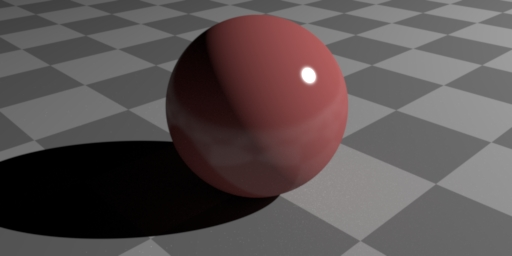


---

### **Task 4: Manipulate Material Parameters and Lighting**

In this task, you will play around with settings for materials and lights. Here's how you can proceed:

#### *1. Examine the XML File:*
* Thoroughly review the comments within the XML file.
* Consult the relevant sections in the [Mitsuba Documentation](https://www.mitsuba-renderer.org/releases/current/documentation_lowres.pdf) to gain deeper insights.

#### *2. Experiment with Various Parameters:*
* Adjust the roughness along one of the two primary directions of anisotropy.
* Alter the lighting source: move from point light to environment map lighting, or utilize both simultaneously.
* Experiment with different BRDF models for the surface. For instance, try substituting the existing model with a Phong model.

#### *3. Address Dynamic Range Concerns:*
* Given that the dynamic range of the scene may extend beyond the [0-1] range, it's vital to tonemap the rendered images.
  * To view the image in low dynamic range:
    * Either save them as tonemapped low dynamic range PNGs via the Mitsuba GUI.
    * Or, utilize the `mtsutil` utility to tonemap the high dynamic range (HDR) output image. More details are available in the Mitsuba manual.

#### *4. Exploring Different Image Formats:*
* Familiarise yourself with the `mfilm`. This tool allows you to save renderings in a binary format compatible with Numpy, with a `.npy` extension.
* Load the saved image using the `numpy.load(filename)` function.
* Alternatively, you can also load the `.exr` image using OpenCV.

---

While diving into this task and using the new software, remember that the goal is to explore, experiment, and learn. Manipulating parameters and observing the changes will give you insights into how materials and lighting behave in the rendering process. Have fun with Mitsuba and enjoy the exploration!


In [ ]:
# Before running this cell, render the scene and upload the image to the session storage!

img = cv2.cvtColor(cv2.imread("VICO_scene_01.exr", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH),cv2.COLOR_BGR2RGB)

# or, if the image was save as mfilm:
# img = np.load('VICO_scene_01.npy')


tonemapper = cv2.createTonemap(gamma=2.2)
img_tonemapped = tonemapper.process(img.copy())
plt.imshow(img_tonemapped)